In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SuchTree import SuchTree
import seaborn

### Calculating distances

`SuchTree` has two ways approaches for calculating distances. One pair a time, or
several large groups of pairs at once. The large groups is more efficient because
it does each calculation without the interpreter's overhead.

In [3]:
T = SuchTree( 'SuchTree/tests/test.tree')

In [4]:
D1 = zeros( ( len(T.leafs),len(T.leafs) ) )
for i,a in enumerate(T.leafs.values()) :
    for j,b in enumerate( T.leafs.values() ) :
        D1[i,j] = T.distance( a, b )

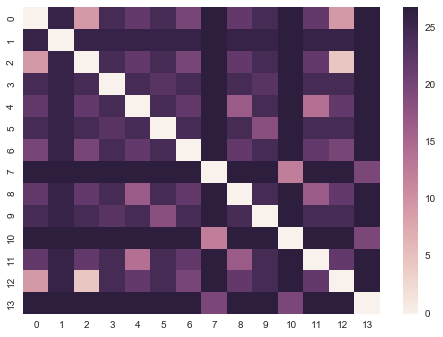

In [5]:
seaborn.heatmap(D1)

In [6]:
D2_list = []
for i,a in enumerate(T.leafs.values()) :
    for j,b in enumerate( T.leafs.values() ) :
        D2_list.append( ( a, b ) )
D2_array = array( D2_list )
D2 = T.distances( D2_array )
D2 = D2.reshape( ( len(T.leafs), len(T.leafs) ) )

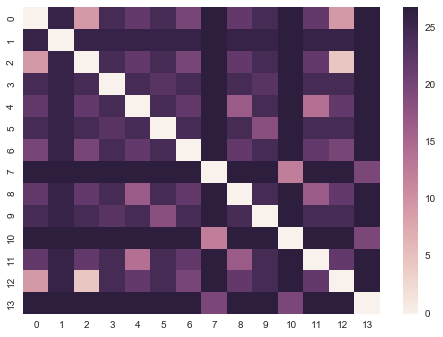

In [7]:
seaborn.heatmap(D2)

### Comparing the topologies of two large trees

Here, we use `SuchTree` to compare the topology of a two trees containing the taxa
but constructe with different methods ([`FastTree`](http://www.microbesonline.org/fasttree/) and 
[`Neighbor_joining`](https://en.wikipedia.org/wiki/Neighbor_joining)). One million random pairs are 
sampled from each tree, and the distances compared.

On my [rather elderly laptop](https://en.wikipedia.org/wiki/ThinkPad_X_Series#X200s), 
the distance calculations in both trees are completed in 5.46 seconds (most of which
is mapping the names to the node indicies).

In [8]:
!wget http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree
!wget http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree_nj.tree

--2016-05-08 02:41:34--  http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree
Resolving edhar.genomecenter.ucdavis.edu (edhar.genomecenter.ucdavis.edu)... 128.120.243.81
Connecting to edhar.genomecenter.ucdavis.edu (edhar.genomecenter.ucdavis.edu)|128.120.243.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2076866 (2.0M)
Saving to: ‘fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree.1’

fishpoo2_p200_c2_un 100%[=====================>]   1.98M  2.47MB/s   in 0.8s   

2016-05-08 02:41:34 (2.47 MB/s) - ‘fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree.1’ saved [2076866/2076866]

--2016-05-08 02:41:35--  http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree_nj.tree
Resolving edhar.genomecenter.ucdavis.edu (edhar.genomecenter.ucdavis.edu)... 128.120.243.81
Connecting to edhar.genomecenter.ucdavis.edu (edhar.genomecenter.ucdavis.edu)|128.120.243.81|:80... connected.
HTTP 

In [4]:
T1 = SuchTree( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree' )
T2 = SuchTree( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree_nj.tree' )

In [10]:
len(T1.leafs), len(T2.leafs)

(54327, 54327)

In [5]:
import random

N = 1000000

v = T1.leafs.values()

pairs = []
for i in range(N) :
    pairs.append( ( random.choice( v ), random.choice( v ) ) )

pairs = array(pairs)    

%time D1 = T1.distances( pairs )
%time D2 = T2.distances( pairs )

Exception Exception: Exception('query contains out of bounds id',) in 'SuchTree.SuchTree._distances' ignored


CPU times: user 13.4 s, sys: 16 ms, total: 13.4 s
Wall time: 13.7 s
CPU times: user 7.33 s, sys: 4 ms, total: 7.33 s
Wall time: 7.39 s


Exception Exception: Exception('query contains out of bounds id',) in 'SuchTree.SuchTree._distances' ignored


In [ ]:
plot( D1, D2, 'ro', alpha=0.2 )

In [ ]:
from scipy.stats import kendalltau, pearsonr

print kendalltau( D1, D2 )
print pearsonr( D1, D2 )

### Running with multiple threads

Another advantage of `SuchTree`'s support for performing batches of distance 
calculations is that these calculations can run outside of Python's 
[global interpreter lock](https://lbolla.info/blog/2013/12/23/python-threads-cython-gil).
This makes it possible to parallelize with [Threads](https://docs.python.org/2/library/threading.html).
Python's `Thread` has less overhead than the
[multiprocessing](https://docs.python.org/2/library/multiprocessing.html) package's
`Process`, and `Thread` objects can access the same memory. 

`SuchTree` intentionally does not allow the user to alter trees once they are created,
and so distance calculations are always thread safe. This makes it possible to use only 
*one* instance of a tree for all threads, which ought to give you the best chance of
keeping it within L2 cache.

In [ ]:
from threading import Thread
from Queue import Queue

n = 2
m = 12

work_q = Queue()
done_q = Queue()

for i in xrange( m ) :
    work_q.put( pairs )

for i in xrange( n ) :
    work_q.put( 'STOP' )
    
def worker( work_q, done_q ) :
    for task in iter( work_q.get, 'STOP' ) :
        D = T1.distances_by_name( task )
        done_q.put( D )
    return True

threads = []

for i in xrange( n ) :
    thread = Thread( target=worker, args=( work_q, done_q ) )
    thread.start()
    threads.append( thread )
    
for thread in threads :
    thread.join()

done_q.put( 'STOP' )

for task in iter( done_q.get, 'STOP' ) :
    print len(task)